Currently `redrock` fails to retreive correct redshifts for a significant number of bright galaxies with strong H$\alpha$ emission lines. One potential solution for this problem will be to re-train the archetypes on a sample that includes the source spectra of these `fail` galaxies. First, I need to construct source spectra for a sample of bright galaxies that represent the redrock failures with strong H$\alpha$ emission lines. 

- [x] update with new synthetic spectra and redrock output

In [1]:
import h5py
import numpy as np 
# -- desi --
from desisim.templates import ELG, LRG, BGS
# -- feasibgs -- 
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

current galaxy archetype templates

In [3]:
f_bgs, w_bgs, _ = BGS().make_templates(10,restframe=True,nocolorcuts=True,seed=1234)

INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


(3000.0, 20000.0)

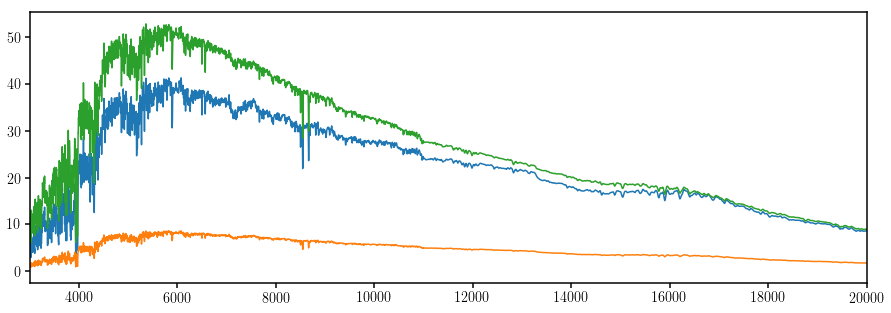

In [4]:
fig = plt.figure(figsize=(15,5))
sub = fig.add_subplot(111)
for i in range(3):
    sub.plot(w_bgs, f_bgs[i])
sub.set_xlim([3e3, 2e4])

In [5]:
# read in GAMA-Legacy catalog
cata = Cat.GamaLegacy()
gleg = cata.Read('g15')

In [6]:
# select properties from the GAMA-Legacy catalog
redshift = gleg['gama-spec']['z']
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude within aperture from Legacy photometry
r_mag_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# r-band magnitude from GAMA (SDSS) photometry
r_mag_gama = gleg['gama-photo']['modelmag_r']
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]
ngal = len(redshift)
print('%i galaxies total' % ngal)

63495 galaxies total


In [7]:
# match galaxies in the catalog to BGS templates
bgs3 = FM.BGStree()
match = bgs3._GamaLegacy(gleg)
hasmatch = (match != -999)
print('%i galaxies do not have matches' % (len(match) - np.sum(hasmatch)))

INFO:io.py:1015:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits metadata.
0 galaxies do not have matches


In the plane of $r$ magnitude versus H$\alpha$ flux, we want to sample galaxies in the parameter space of redrock failures with low $r$ mag and high H$\alpha$. As a fiducial cut for the redrock failure targets lets start with a simple $r$ magnitude and H$\alpha$ flux cut

(H$\alpha$ line flux > $10^3 \times 10^{-17}erg/s/cm^2$) and ($r$ magnitude < 20.)

(0.005, 100000.0)

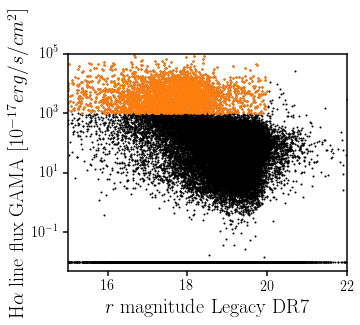

In [8]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
hashalpha = (gama_ha > 0.)
sub.scatter(r_mag_legacy[hashalpha], gama_ha[hashalpha], c='k', s=1)
sub.scatter(r_mag_legacy[~hashalpha], np.repeat(1e-2, np.sum(~hashalpha)), c='k', s=1)

fail_archetype = (r_mag_legacy < 20.) & (gama_ha > 1e3)
sub.scatter(r_mag_legacy[fail_archetype], gama_ha[fail_archetype], c='C1', s=2)

sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'H$\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_yscale('log')
sub.set_ylim([5e-3, 1e5])

In [9]:
fail_sample = np.random.choice(np.arange(ngal)[fail_archetype], 500)

(0.005, 100000.0)

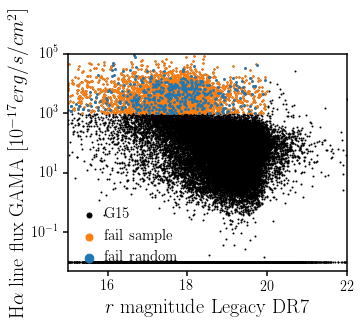

In [10]:
fig = plt.figure(figsize=(5, 4))
sub = fig.add_subplot(111)
hashalpha = (gama_ha > 0.)
sub.scatter(r_mag_legacy[hashalpha], gama_ha[hashalpha], c='k', s=1, label='G15')
sub.scatter(r_mag_legacy[~hashalpha], np.repeat(1e-2, np.sum(~hashalpha)), c='k', s=1)

fail_archetype = (r_mag_legacy < 20.) & (gama_ha > 1e3)
sub.scatter(r_mag_legacy[fail_archetype], gama_ha[fail_archetype], c='C1', s=2, label='fail sample')

sub.scatter(r_mag_legacy[fail_sample], gama_ha[fail_sample], c='C0', s=3, label='fail random')
sub.legend(loc=(0., 0.), markerscale=5, handletextpad=0., fontsize=15)
sub.set_xlabel(r'$r$ magnitude Legacy DR7', fontsize=20)
sub.set_xlim([15., 22.])
sub.set_ylabel(r'H$\alpha$ line flux GAMA $[10^{-17}erg/s/cm^2]$', fontsize=20)
sub.set_yscale('log')
sub.set_ylim([5e-3, 1e5])

In [16]:
vdisp = np.repeat(100., ngal)
# calculate source spectra from templates
s_bgs = FM.BGSsourceSpectra(wavemin=1200, wavemax=2e4)

INFO:io.py:1027:read_basis_templates: Reading /Volumes/chang_eHDD/projects/desi/spectro/templates/basis_templates/v2.5/bgs_templates_v2.1.fits


In [17]:
# emission lines from GAMA
emline_flux = s_bgs.EmissionLineFlux(gleg, index=np.arange(ngal)[fail_sample], dr_gama=3, silent=True)

In [18]:
flux_eml, wave, _, magnorm_flag = s_bgs.Spectra(r_mag_apflux[fail_sample], redshift[fail_sample],
                                  vdisp[fail_sample], seed=1, templateid=match[fail_sample],
                                  emflux=emline_flux, mag_em=r_mag_gama[fail_sample], silent=False)

--------------------
the 4 th galaxy has brighter emission lines than photometry...
--------------------
the 11 th galaxy has brighter emission lines than photometry...
--------------------
the 36 th galaxy has brighter emission lines than photometry...
--------------------
the 51 th galaxy has brighter emission lines than photometry...
--------------------
the 108 th galaxy has brighter emission lines than photometry...
--------------------
the 114 th galaxy has brighter emission lines than photometry...
--------------------
the 132 th galaxy has brighter emission lines than photometry...
--------------------
the 135 th galaxy has brighter emission lines than photometry...
--------------------
the 154 th galaxy has brighter emission lines than photometry...
--------------------
the 239 th galaxy has brighter emission lines than photometry...
--------------------
the 255 th galaxy has brighter emission lines than photometry...
--------------------
the 277 th galaxy has brighter emissio

(0.0, 20.0)

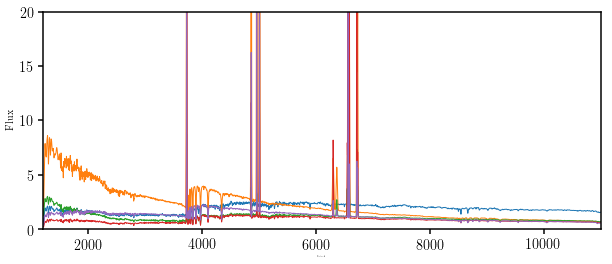

In [19]:
fig = plt.figure(figsize=(10, 4))
sub = fig.add_subplot(111)
for i in np.random.choice(np.arange(len(fail_sample))[magnorm_flag], 5): 
    sub.plot(wave/(1.+redshift[fail_sample][i]), flux_eml[i,:], lw=1)
sub.set_xlabel('Wavelength [$\AA$]', fontsize=0)
sub.set_xlim([1200., 1.1e4])
sub.set_ylabel('Flux')
sub.set_ylim([0., 20.])

In [23]:
f = h5py.File(''.join([UT.dat_dir(), 'spectra/gamadr3_legacydr7/', 'g15.sourceSpectra.fail_archetype.hdf5']), 'w')
f.create_dataset('wave', data=np.array([wave/(1.+z) for z in redshift[fail_sample]]))
f.create_dataset('flux', data=flux_eml[magnorm_flag,:])
f.close()